# Image Pixelization / De-Pixelization Demo

This notebook demonstrates how to create a pixelated animation from an original image and then attempt to reconstruct an image from these pixelated blocks.\
The pixelation effect is achieved using a `nearest` neighbor filter during downsampling and upsampling of a moving window.


## 1. Load Original Image

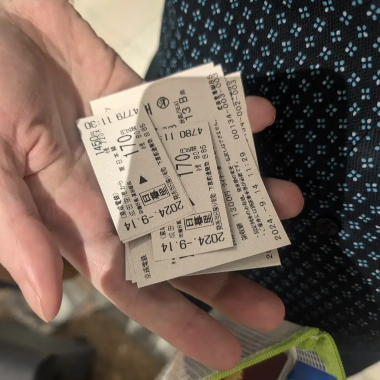

In [1]:
import PIL.Image as Image
import torchvision.transforms.functional as TF

original = TF.to_tensor(Image.open('template.png').convert('RGBA')).unsqueeze_(0)

H, W = original.size()[-2:]

TF.to_pil_image(original[0])

## 2. Generate a Motion for the Pixelation

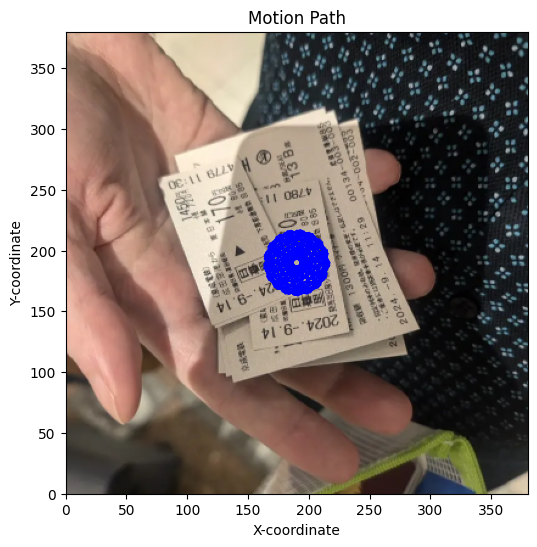

In [2]:
import math

CHUNK_SIZE = 16
NUM_FRAMES = 250
AREA_SIZE = min(W, H) // 2 // CHUNK_SIZE * CHUNK_SIZE

# generate the motion of the pixelation
motion = []
for i in range(NUM_FRAMES):
    motion.append((
        W / 2 + math.cos(i / NUM_FRAMES * math.pi * 2) * AREA_SIZE / CHUNK_SIZE + math.cos(i) * CHUNK_SIZE,
        H / 2 + math.sin(i / NUM_FRAMES * math.pi * 2) * AREA_SIZE / CHUNK_SIZE + math.sin(i) * CHUNK_SIZE
    ))

# display the path
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
plt.imshow(TF.to_pil_image(TF.vflip(original[0])))
plt.plot(
    [m[0] for m in motion],
    [m[1] for m in motion],
    linestyle='-',
    color='b'
)
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")
plt.title("Motion Path")
plt.xlim(0, W)
plt.ylim(0, H)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

## 3. Pixelate


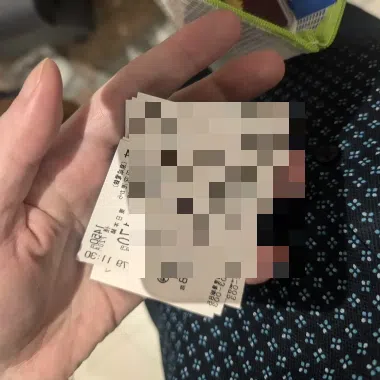

In [3]:
import torch
import torch.nn.functional as F

frames_pixelated = torch.zeros((NUM_FRAMES, 4, H, W))
frames_pixelated[:] = original

for i, (shift_x, shift_y) in enumerate(motion):
    x_start = round(shift_x - AREA_SIZE / 2)
    x_end = x_start + AREA_SIZE
    y_start = round(shift_y - AREA_SIZE / 2)
    y_end = y_start + AREA_SIZE
    frames_pixelated[
        i:i+1,
        ...,
        y_start:y_end,
        x_start:x_end
    ] = F.interpolate(
        F.interpolate(
            original[
                ...,
                y_start:y_end,
                x_start:x_end
            ],
            size=(AREA_SIZE // CHUNK_SIZE, AREA_SIZE // CHUNK_SIZE),
            mode='nearest' # use NEAREST-FILTER
        ),
        size=(AREA_SIZE, AREA_SIZE),
        mode='nearest'
    )

# quantize to 8bit
frames_pixelated = frames_pixelated.mul(0xFF).to(torch.uint8).float().div(0xFF)

def display_frames(title, frames):
    pil_images = [TF.to_pil_image(TF.vflip(frame)) for frame in frames]
    import io
    byte_arr = io.BytesIO()
    pil_images[0].save(
        byte_arr,
        format='WEBP',
        save_all=True,
        append_images=pil_images[1:],
        duration=50,
        loop=0,
        quality=80  # Adjust quality as needed
    )
    import base64
    encoded_webp = base64.b64encode(byte_arr.getvalue()).decode('ascii')
    html_output = f'<img src="data:image/webp;base64,{encoded_webp}">'
    return html_output

from IPython.display import HTML
HTML(display_frames("Pixelated", frames_pixelated))

## 4. Collect all Pixels and put them at their Global Position 

this is of course just a best case secenario, extracting the motion would be very easy.\
in this case we will just reuse the motion, we used to generate the pixelation.


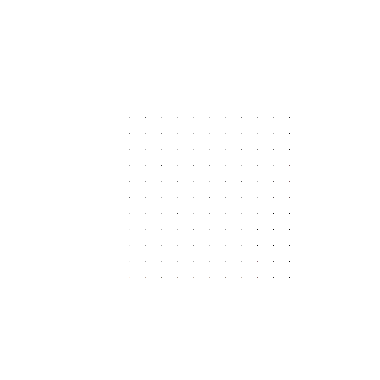

In [4]:
frame_pixels = torch.zeros((NUM_FRAMES, 4, H, W))

for i, (shift_x, shift_y) in enumerate(motion):
    x_start = round(shift_x - AREA_SIZE / 2)
    x_end = x_start + AREA_SIZE
    y_start = round(shift_y - AREA_SIZE / 2)
    y_end = y_start + AREA_SIZE
    frame_pixels[
        i:i+1, ...,
        y_start:y_end:CHUNK_SIZE,
        x_start:x_end:CHUNK_SIZE
    ] = F.interpolate(frames_pixelated[
        i:i+1,
        ...,
        y_start:y_end,
        x_start:x_end
    ], size=(AREA_SIZE // CHUNK_SIZE, AREA_SIZE // CHUNK_SIZE), mode='area')

HTML(display_frames("Pixels", frame_pixels))

## 5. Accumulate Pixels into Single Frame

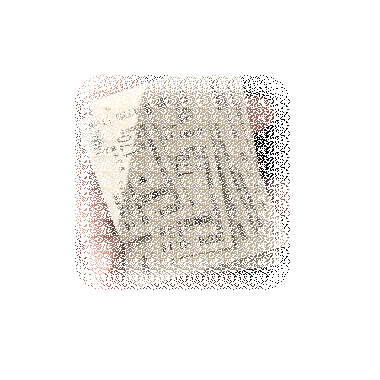

In [5]:
frame_accumulated = frame_pixels.sum(0, keepdim=True)
frame_accumulated = frame_accumulated / frame_accumulated[:,-1:]
frame_accumulated[~torch.isfinite(frame_accumulated)] = 0.0

TF.to_pil_image(frame_accumulated[0])

## 6. Grow the Pixels

this is just to make the result more readable

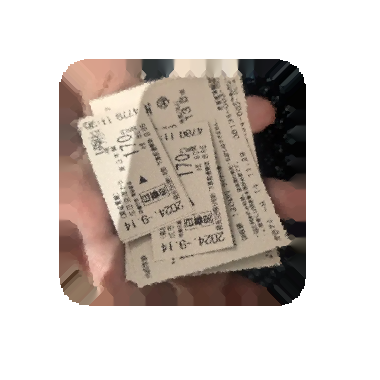

In [6]:
frame_grown = frame_accumulated.clone()

for _ in range(CHUNK_SIZE):
  c = frame_grown[:, -1:] == 0
  x = F.avg_pool2d(frame_grown, 3, 1, 1, False, False, 1)
  frame_grown += c.float() * x

frame_grown = frame_grown / frame_grown[:, -1:]
frame_grown[~torch.isfinite(frame_grown)] = 0.0

TF.to_pil_image(frame_grown[0])